##### Copyright 2018 The TensorFlow Authors.

In [44]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

## Setup

In [45]:
!export LC_ALL=C

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
np.set_printoptions(precision = 3, suppress = True)

Import `matplotlib` and create a helper function to plot graphs:

In [46]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


[35843, 34778]


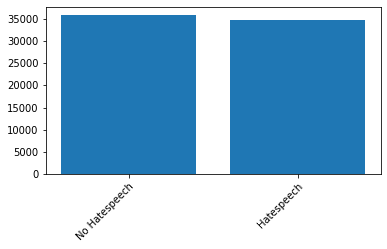

<Figure size 1152x432 with 0 Axes>

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_emotions(split='train'):
    dataset, info = tfds.load('goemotions', with_info = True, split = split)
    emotions = tfds.as_dataframe(ds = dataset)
    emotions = emotions.rename(columns = {'comment_text': 'text'})
    rem = [
        'admiration',
        'amusement',
        'anger',
        'annoyance',
        'approval',
        'caring',
        'confusion',
        'curiosity',
        'desire',
        'disappointment',
        'disapproval',
        'disgust',
        'embarrassment',
        'excitement',
        'fear',
        'gratitude',
        'grief',
        'joy',
        'love',
        'nervousness',
        'neutral',
        'optimism',
        'pride',
        'realization',
        'relief',
        'remorse',
        'sadness',
        'surprise',
    ]

    emotions = emotions[emotions.columns.drop(rem)]
    emotions['is_hatespeech'] = 0
    return emotions


#
# Load the csv data.
#
def load_data_arrays():
    df_1 = pd.read_csv("datasets/1_no_stopwords.csv")
    df_3 = pd.read_csv("datasets/3_no_stopwords.csv")

    #    df_5 = pd.read_csv("datasets/5_no_stopwords.csv")

    df_6 = pd.read_csv("datasets/6_no_stopwords.csv")

    df = df_1.append(df_3)
    df = df.append(df_6)

    train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True,
                                         stratify = df["is_hatespeech"])

    emo_df = pd.read_csv('./datasets/goemotions.csv', encoding = 'utf-8')

    emo_1, emo_2 = train_test_split(emo_df, test_size = 0.4, random_state = 42, shuffle = True)

    train_df = df.append(emo_2)
    # emo_df = load_emotions()
    # emo_df = emo_df.append(load_emotions('test'))
    # emo_df = emo_df.append(load_emotions('validation'))


    return train_df, test_df


def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    print([total.count(bin_val) for bin_val in bins])
    plt.xticks(bins,
               ["No Hatespeech", "Hatespeech"],
               rotation = 45,
               rotation_mode = "anchor",
               ha = "right")

    plt.subplots_adjust(bottom = 0.3)
    plt.figure(figsize = (16, 6))
    plt.show()


train_df, test_df = load_data_arrays()

plot_data_distribution(train_df['is_hatespeech'].values, test_df['is_hatespeech'].values)

In [48]:
# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = tf.keras.utils.to_categorical(train_df['is_hatespeech'].values, num_classes = 2)
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype = str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = tf.keras.utils.to_categorical(test_df['is_hatespeech'].values, num_classes = 2)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype = str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [49]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [50]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, 42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [51]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy())
    print()
    print('labels: ', label.numpy())

texts:  [b'i found new way chug open mouth alot shitallysays'
 b'pornandroidiphoneipadsexxxx handjob hand job cum rubber pussy'
 b'dont worry nigga see worry nigga dont see dats da nigga fuckin yo bitch'
 b'yankees take three games motown im callin it mlb'
 b'pornandroidiphoneipadsexxxx desi paki' b'chilling sexy scally lad'
 b'and bitch must lost' b'happy bday bitch ass nigga bitch roll up'
 b'bored supposed cute faggot sometimes' b'i got hicks lol'
 b'tikiti rough mock base eventually ashtray tiki ti'
 b'virginia full white trash'
 b'pornandroidiphoneipadsexxxx korean korean girlfriend pussy'
 b'rt me please thanks did pierced pussy come across timeline'
 b'just follow yellow brick twitter'
 b'rt these bitches started shooting party fuck new orleans'
 b'bartending becomes real bitch bartender way way taller bar designed for holy back pains'
 b'bruh im tired niggas retweetin miley cyrus naked bitch aint types bad lmaooo'
 b'how draft gungho folks send afghanistan war zones show their'

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [52]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [53]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'the', 'rt', 'bitch', 'a', 'to', 'you', 'like',
       'and', 'it', 'is', 'that', 'im', 'this', 'of', 'mkr', 'name', 'in'],
      dtype='<U15')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [54]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 534, 133, 102,   1, 511, 644,   1,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  1,   1, 684, 341,   1,   1,  28,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [ 58, 817,  70,  62, 817,  70,  58,  62,   1, 308,  70, 329, 135,
          5,   0,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [55]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'i found new way chug open mouth alot shitallysays'
Round-trip:  i found new way [UNK] open mouth [UNK] [UNK]         

Original:  b'pornandroidiphoneipadsexxxx handjob hand job cum rubber pussy'
Round-trip:  [UNK] [UNK] hand job [UNK] [UNK] pussy           

Original:  b'dont worry nigga see worry nigga dont see dats da nigga fuckin yo bitch'
Round-trip:  dont worry nigga see worry nigga dont see [UNK] da nigga fuckin yo bitch    



## Create the model

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [56]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        # Use masking to handle the variable sequence lengths
        mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

print(model.summary())

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.001),
              metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 138,434
Trainable params: 138,434
Non-tr

## Train the model

In [57]:
history = model.fit(train_dataset, epochs = 5,
                    validation_data = test_dataset,
                    validation_steps = 10)

Epoch 1/5
977/977 [==============================] - 26s 21ms/step - loss: 0.1256 - accuracy: 0.9518 - val_loss: 6.0997 - val_accuracy: 0.3234
Epoch 2/5
977/977 [==============================] - 21s 21ms/step - loss: 0.1141 - accuracy: 0.9594 - val_loss: 6.1343 - val_accuracy: 0.3750
Epoch 3/5
977/977 [==============================] - 21s 21ms/step - loss: 0.1134 - accuracy: 0.9619 - val_loss: 3.7009 - val_accuracy: 0.4797
Epoch 4/5
977/977 [==============================] - 20s 20ms/step - loss: 0.1022 - accuracy: 0.9646 - val_loss: 2.5049 - val_accuracy: 0.4875
Epoch 5/5
977/977 [==============================] - 20s 21ms/step - loss: 0.0981 - accuracy: 0.9646 - val_loss: 2.6539 - val_accuracy: 0.4203


In [58]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

128/128 [==============================] - 1s 8ms/step - loss: 2.8327 - accuracy: 0.4205
Test Loss: 2.832691192626953
Test Accuracy: 0.42045873403549194


(0.0, 6.436116675287485)

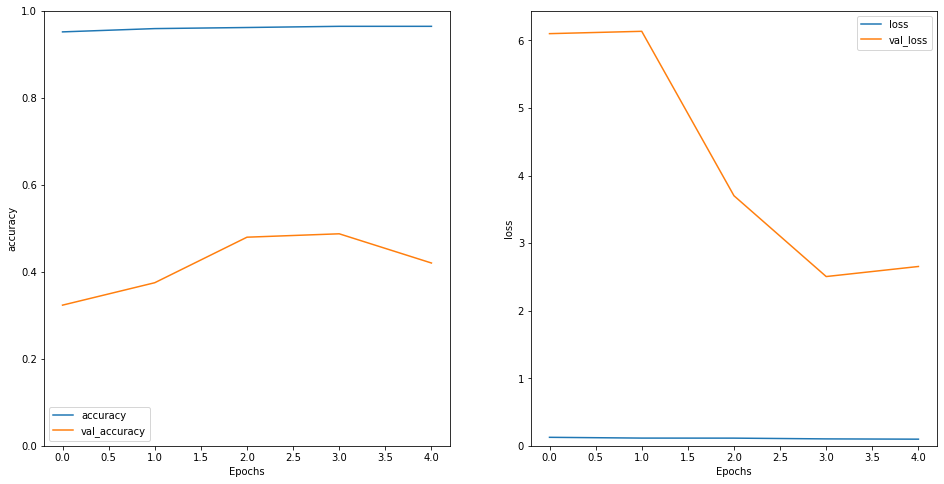

In [59]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)